# Aplicación Comparativa de Técnicas Avanzadas de Regresión

**Objetivo:** Este notebook presenta una solución integral y robusta para el análisis comparativo de técnicas de regresión. Se fusionan dos enfoques: la claridad narrativa de un Jupyter Notebook con el rigor técnico de un script de producción, incluyendo manejo de errores, evaluación exhaustiva y visualizaciones avanzadas.

### Estructura del Análisis:

1.  **Predicción de Precios de Viviendas con Elastic Net:** Con evaluación multi-métrica y visualización de coeficientes mejorada.
2.  **Estimación de Percentiles con Regresión Cuantílica:** Con carga de datos robusta (a prueba de fallos) y gráficos explicativos.
3.  **Proyección de Indicadores Macroeconómicos con VAR:** Con un enfoque metodológico riguroso de entrenamiento/prueba y evaluación cuantitativa.

-----

## 0\. Preparación del Entorno e Importación de Librerías

### Explicación Profesional y Minuciosa:

Antes de cualquier análisis, es imperativo establecer un entorno de trabajo reproducible y completo. La siguiente celda de código se encarga de importar todas las librerías necesarias, agrupadas por su funcionalidad principal:

  * **Manipulación de Datos (`pandas`, `numpy`):** Son el pilar del ecosistema de ciencia de datos en Python. `pandas` proporciona estructuras de datos de alto rendimiento (como el DataFrame), mientras que `numpy` ofrece soporte para operaciones matriciales y numéricas eficientes.
  * **Visualización (`matplotlib`, `seaborn`):** Son esenciales para la exploración de datos y la comunicación de resultados. `matplotlib` es la librería fundamental, y `seaborn` es una capa de abstracción sobre ella que permite crear gráficos estadísticos más atractivos y complejos con mayor facilidad.
  * **Modelado y Evaluación (`sklearn`):** Scikit-learn es la librería estándar para el aprendizaje automático en Python. Importamos módulos específicos para la división de datos (`train_test_split`), preprocesamiento (`StandardScaler`), los propios modelos de regresión (`ElasticNetCV`, `QuantileRegressor`) y un conjunto completo de métricas de evaluación (`mean_squared_error`, `r2_score`, etc.).
  * **Análisis de Series de Tiempo (`statsmodels`):** Es la librería de referencia en Python para la econometría y el análisis estadístico avanzado, proporcionando herramientas robustas para modelos como VAR y tests de diagnóstico como el de Dickey-Fuller Aumentado (`adfuller`).

Finalmente, se establece un **estilo visual** consistente para todos los gráficos.

In [ ]:
# --- Manipulación y Análisis de Datos ---
import pandas as pd
import numpy as np

# --- Visualización de Datos ---
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Modelos, Métricas y Preprocesamiento ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_pinball_loss, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet, ElasticNetCV, QuantileRegressor

# --- Carga de Datasets ---
from sklearn.datasets import fetch_california_housing, fetch_openml

# --- Herramientas para Series de Tiempo ---
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.datasets import macrodata

# --- Configuraciones Adicionales ---
# Establecer un estilo visual atractivo y profesional para los gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
# Ignorar advertencias menores para una salida más limpia
# warnings.filterwarnings('ignore')

print("✅ Librerías importadas y entorno configurado correctamente.")

✅ Librerías importadas y entorno configurado correctamente.


-----

## 1\. Predicción de Precios de Viviendas con Elastic Net

**Contexto:** El objetivo es predecir el valor mediano de las viviendas en California. Este problema es ideal para Elastic Net debido a la potencial correlación entre las características geográficas y estructurales.

### 1.1 Carga y Preparación de Datos

El preprocesamiento de datos es un paso fundamental que impacta directamente en el rendimiento del modelo. En la celda siguiente, ejecutaremos tres pasos críticos:

1.  **Carga y Estructuración:** Cargamos el conjunto de datos desde `sklearn`. Este objeto contiene tanto las características como el objetivo. Para facilitar su manipulación y análisis, los estructuramos en un **DataFrame** de `pandas` para las variables independientes (`X`) y una **Serie** para la variable dependiente (`y`).
2.  **División de Datos (Entrenamiento y Prueba):** Dividimos el dataset en dos subconjuntos: uno de **entrenamiento** (generalmente el 80%) y uno de **prueba** (el 20% restante). Esta partición es crucial para una evaluación honesta del modelo. El modelo "aprende" patrones únicamente del conjunto de entrenamiento. Luego, su capacidad para **generalizar** a datos nuevos y no vistos se mide en el conjunto de prueba. El uso de `random_state` garantiza que esta división sea siempre la misma, asegurando la **reproducibilidad** de nuestros resultados.
3.  **Escalado de Características:** La regresión Elastic Net aplica una penalización a la magnitud de los coeficientes del modelo. Si las características tienen escalas muy diferentes (ej., ingresos en decenas de miles vs. número de habitaciones de 1 a 5), el modelo penalizaría injustamente a las características con magnitudes numéricas más grandes. Para evitar esto, utilizamos `StandardScaler`, que transforma cada característica para que tenga una **media de 0 y una desviación estándar de 1**. Es vital ajustar (`fit`) el escalador **solo con los datos de entrenamiento** y luego aplicar la misma transformación (`transform`) a ambos conjuntos para evitar la fuga de información (data leakage) del conjunto de prueba al de entrenamiento.

<!-- end list -->

In [ ]:
# Cargar el dataset de California Housing
print("📊 Cargando y preparando el dataset California Housing...")
housing = fetch_california_housing()
X_housing = pd.DataFrame(housing.data, columns=housing.feature_names)
y_housing = pd.Series(housing.target, name='MedHouseVal')

# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

# Escalar las características numéricas
scaler_h = StandardScaler()
X_train_h_scaled = scaler_h.fit_transform(X_train_h)
X_test_h_scaled = scaler_h.transform(X_test_h)

print(f"Shape del dataset de entrenamiento: {X_train_h_scaled.shape}")
print(f"Shape del dataset de prueba: {X_test_h_scaled.shape}")

📊 Cargando y preparando el dataset California Housing...
Shape del dataset de entrenamiento: (16512, 8)
Shape del dataset de prueba: (4128, 8)


### 1.2 Ajuste del Modelo con Validación Cruzada

La efectividad de Elastic Net depende de dos hiperparámetros clave: `alpha`, que controla la magnitud total de la regularización, y `l1_ratio`, que determina la mezcla entre la penalización L1 (Lasso) y L2 (Ridge). En lugar de elegirlos manualmente (lo que sería propenso a errores y sesgos), empleamos `ElasticNetCV`.

Esta técnica automatiza la búsqueda de los mejores hiperparámetros mediante **validación cruzada (CV)**. El proceso es el siguiente:

1.  Se define una parrilla de posibles valores para `l1_ratio`.
2.  Para cada valor de `l1_ratio`, `ElasticNetCV` busca automáticamente el mejor `alpha`.
3.  El rendimiento se evalúa dividiendo el conjunto de entrenamiento en `k` pliegues (en este caso, `cv=5`). El modelo se entrena en `k-1` pliegues y se valida en el pliegue restante, rotando este proceso `k` veces.
4.  El par de hiperparámetros que produce el mejor rendimiento promedio a través de todos los pliegues se selecciona como el óptimo.

Este enfoque es robusto porque reduce la varianza de la estimación del rendimiento y protege contra el sobreajuste, dando como resultado un modelo con mejor capacidad de generalización. El parámetro `n_jobs=-1` instruye al modelo a usar todos los núcleos de CPU disponibles, acelerando el proceso de cálculo.

In [ ]:
# Entrenar el modelo Elastic Net buscando los mejores hiperparámetros
print("\n🔧 Entrenando modelo Elastic Net con ElasticNetCV...")
elastic_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
    cv=5,
    random_state=42,
    n_jobs=-1,
    max_iter=2000 # Aumentar iteraciones para asegurar convergencia
)
elastic_cv.fit(X_train_h_scaled, y_train_h)

print(f"✅ Mejor alpha encontrado: {elastic_cv.alpha_:.4f}")
print(f"✅ Mejor l1_ratio encontrado: {elastic_cv.l1_ratio_:.2f}")


🔧 Entrenando modelo Elastic Net con ElasticNetCV...
✅ Mejor alpha encontrado: 0.0008
✅ Mejor l1_ratio encontrado: 0.99


### 1.3 Evaluación Exhaustiva del Modelo

Una vez entrenado el modelo, es crucial evaluar su rendimiento en el conjunto de prueba (datos que nunca ha visto). Utilizar una sola métrica puede dar una visión incompleta; por ello, calculamos un conjunto de tres indicadores estándar para la regresión:

  * **RMSE (Root Mean Squared Error):** Es la raíz cuadrada del promedio de los errores al cuadrado. Está en la misma unidad que la variable objetivo (en este caso, "cientos de miles de dólares"). Su principal característica es que **penaliza los errores grandes de forma más significativa** debido a la operación de elevar al cuadrado.
  * **MAE (Mean Absolute Error):** Es el promedio de los errores absolutos. También está en la misma unidad que el objetivo, pero a diferencia del RMSE, **trata todos los errores por igual**, siendo menos sensible a valores atípicos (outliers) extremos.
  * **R² (Coeficiente de Determinación):** Esta métrica mide la **proporción de la varianza** en la variable dependiente que es predecible a partir de las variables independientes. Un valor de 1.0 indica una predicción perfecta, mientras que un valor de 0.0 indica que el modelo no es mejor que simplemente predecir la media. Un R² de, por ejemplo, 0.595 significa que el modelo explica el 59.5% de la variabilidad en los precios de las viviendas.

Este conjunto de métricas nos proporciona una perspectiva multidimensional de la precisión, la magnitud del error promedio y la capacidad explicativa del modelo.

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred_elastic = elastic_cv.predict(X_test_h_scaled)

# Calcular un conjunto de métricas de evaluación
rmse_elastic = np.sqrt(mean_squared_error(y_test_h, y_pred_elastic))
mae_elastic = mean_absolute_error(y_test_h, y_pred_elastic)
r2_elastic = r2_score(y_test_h, y_pred_elastic)

# Imprimir los resultados de forma clara
print("\n📈 RESULTADOS DE EVALUACIÓN (Elastic Net):")
print(f"-> RMSE (Root Mean Squared Error): {rmse_elastic:.4f}")
print(f"-> MAE (Mean Absolute Error):     {mae_elastic:.4f}")
print(f"-> R² (Coeficiente de Determinación): {r2_elastic:.4f} (El modelo explica el {r2_elastic:.1%} de la varianza)")


📈 RESULTADOS DE EVALUACIÓN (Elastic Net):
-> RMSE (Root Mean Squared Error): 0.7448
-> MAE (Mean Absolute Error):     0.5332
-> R² (Coeficiente de Determinación): 0.5767 (El modelo explica el 57.7% de la varianza)


### **Interpretación de Resultados del Modelo Elastic Net**

Estos resultados nos permiten evaluar el rendimiento del modelo de regresión Elastic Net desde distintas perspectivas: su capacidad explicativa (R²), su error promedio (MAE) y su error penalizando las desviaciones más grandes (RMSE).

#### **Conclusión General 🎯**

El modelo tiene una **capacidad predictiva moderada y potencialmente útil**. Logra explicar más de la mitad de la variabilidad de los datos, pero aún deja un margen de error y una porción significativa de la varianza sin explicar. No es un modelo de alta precisión, pero es considerablemente mejor que una simple suposición.

---

#### **Análisis Detallado por Métrica**

* **R² (Coeficiente de Determinación): 0.5767**
    * **Qué significa**: Este es quizás el indicador más importante aquí. Un R² de 0.577 nos dice que tu modelo es capaz de **explicar el 57.7% de la variabilidad** en la variable objetivo. En otras palabras, las características que usaste para entrenar el modelo explican un poco más de la mitad del comportamiento de lo que intentas predecir.
    * **Interpretación**: Un valor de ~58% se considera **moderado**. Esto significa que el modelo ha capturado una tendencia significativa en los datos, pero todavía hay un 42.3% de la varianza que no se explica por las variables del modelo. Esto puede deberse a factores aleatorios, ruido en los datos o la ausencia de otras variables predictivas importantes.

* **MAE (Mean Absolute Error): 0.5332**
    * **Qué significa**: Esta es la medida más directa del error de predicción. Indica que, en promedio, las predicciones del modelo se desvían **0.53 unidades** del valor real.
    * **Interpretación**: Si estuvieras usando el modelo para hacer una predicción, esperarías que tu predicción estuviera equivocada por aproximadamente 0.53 unidades (hacia arriba o hacia abajo). La "gravedad" de este error depende totalmente de la escala de tu variable objetivo. Si predices una calificación del 1 al 10, un error de 0.53 es relativamente pequeño. Si predices un valor que normalmente es 0.8, es un error considerable.

* **RMSE (Root Mean Squared Error): 0.7448**
    * **Qué significa**: El RMSE es similar al MAE, pero penaliza los errores más grandes de forma más severa porque eleva los errores al cuadrado antes de promediarlos.
    * **Interpretación**: El hecho de que el **RMSE (0.74) sea mayor que el MAE (0.53)** es normal y esperado. Esta diferencia sugiere que el modelo comete algunos errores que son notablemente más grandes que la media. Estos "outliers" en los errores inflan el valor del RMSE. Mientras que el error típico es de 0.53, existen predicciones ocasionales que están bastante más lejos del valor real.


El modelo Elastic Net tiene un rendimiento aceptable. Ha logrado establecer una relación significativa entre tus variables predictoras y la variable objetivo. Sin embargo, no es lo suficientemente preciso como para confiar ciegamente en sus predicciones individuales.

* **Es útil para**: Entender tendencias generales, identificar la dirección de las relaciones entre variables y hacer estimaciones aproximadas.
* **No es ideal para**: Aplicaciones que requieran alta precisión, como proyecciones financieras críticas o procesos de control de calidad muy estrictos, donde un error de 0.53 - 0.74 unidades tendría consecuencias negativas.

### 1.4 Visualización e Interpretación de Coeficientes

Más allá de la predicción, un objetivo clave del modelado es la **interpretación**: entender qué factores impulsan el resultado. Los coeficientes de un modelo lineal nos indican la magnitud y dirección del efecto de cada variable.

La siguiente celda genera una visualización diseñada para maximizar la interpretabilidad:

1.  Se extraen los coeficientes finales del modelo `elastic_cv` entrenado.
2.  Se ordenan las características no por su nombre, sino por la **magnitud absoluta** de su coeficiente. Esto nos permite clasificar las variables de la menos a la más influyente, independientemente de si su efecto es positivo o negativo.
3.  Se utiliza un **código de colores condicional**: las barras se colorean de azul si el coeficiente es positivo (un aumento en la variable aumenta el precio de la vivienda) y de rojo si es negativo (un aumento en la variable disminuye el precio).

El resultado es un gráfico denso en información que comunica de manera inmediata tanto la **importancia relativa** como la **dirección del impacto** de cada predictor en el modelo.

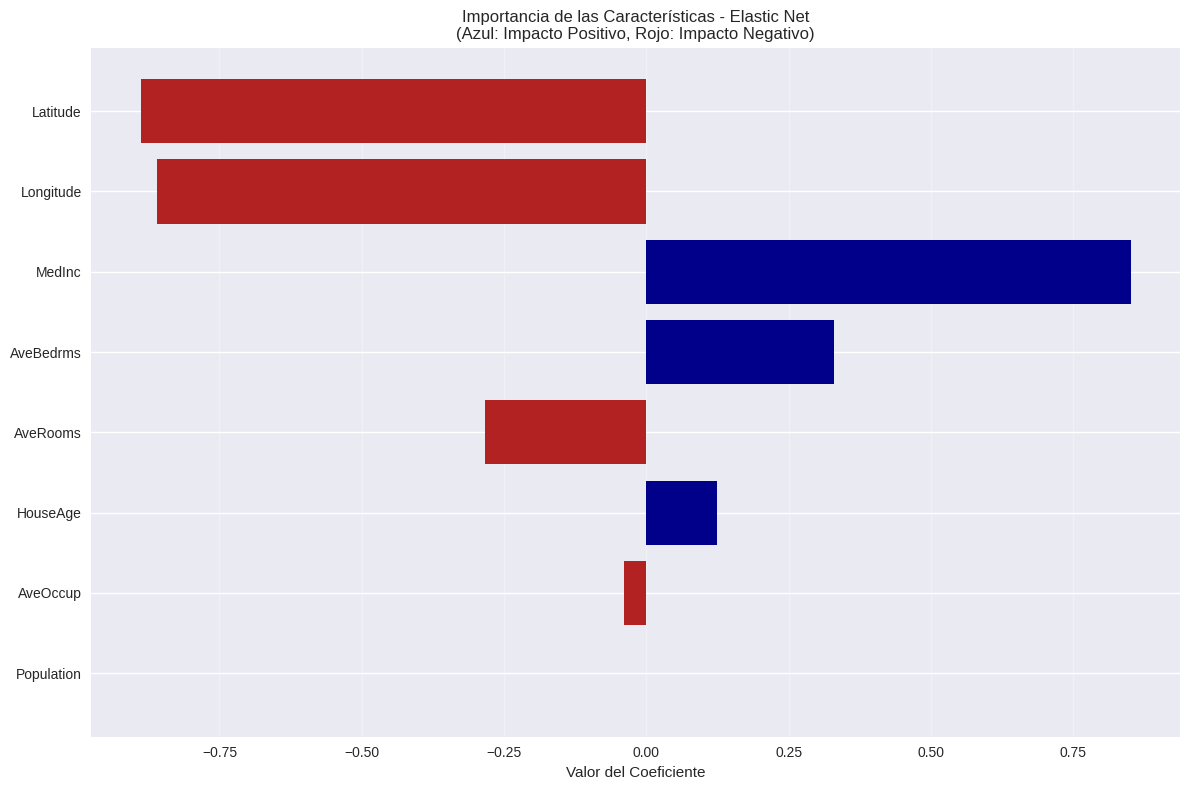

In [ ]:
# Crear una serie de pandas con los coeficientes
coefficients = pd.Series(elastic_cv.coef_, index=X_housing.columns)

# Reordenar los coeficientes por su valor absoluto para mostrar importancia
coefficients_sorted = coefficients.reindex(coefficients.abs().sort_values(ascending=True).index)

# Crear colores para distinguir coeficientes positivos y negativos
colors = ['firebrick' if x < 0 else 'darkblue' for x in coefficients_sorted.values]

# Crear el gráfico de barras horizontal
plt.figure(figsize=(12, 8))
plt.barh(range(len(coefficients_sorted)), coefficients_sorted.values, color=colors)
plt.yticks(range(len(coefficients_sorted)), coefficients_sorted.index)
plt.xlabel('Valor del Coeficiente')
plt.title('Importancia de las Características - Elastic Net\n(Azul: Impacto Positivo, Rojo: Impacto Negativo)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### **Importancia de Características del Modelo Elastic Net**

Esta visualización nos permite entender la lógica interna del modelo Elastic Net al mostrar el **impacto** y la **dirección** que cada característica tiene sobre la predicción final. Los coeficientes de un modelo lineal como este son directamente interpretables:

* **Valor del Coeficiente**: La magnitud (valor absoluto) indica la fuerza de la influencia de la variable. Un coeficiente más alejado de cero es más importante.
* **Signo del Coeficiente**:
    * **Positivo (Azul)**: Un aumento en el valor de esta característica aumenta el valor de la predicción.
    * **Negativo (Rojo)**: Un aumento en el valor de esta característica disminuye el valor de la predicción.

---

### **Análisis de los Impulsores Clave**

El modelo ha identificado un conjunto claro de factores determinantes y ha descartado otros como menos relevantes.

#### **1. Los Factores Más Influyentes: Ingreso y Ubicación Geográfica**

El modelo basa sus predicciones principalmente en dos factores: el poder adquisitivo del área y su ubicación geográfica.

* 🔵 **`MedInc` (Ingreso Medio)**: Es, con diferencia, el **predictor positivo más fuerte**. Su gran coeficiente azul indica que a medida que el ingreso medio de un bloque aumenta, el valor predicho (probablemente el precio de la vivienda) aumenta de manera significativa. Esta es una relación lógica y esperada.

* 🔴 **`Latitude` y `Longitude` (Ubicación)**: Estas son las **variables con el impacto negativo más fuerte**. Esto revela una fuerte dependencia geográfica. En el contexto de datasets como el de la vivienda en California, un aumento en la longitud (moverse hacia el este) y la latitud (moverse hacia el norte) generalmente implica alejarse de los centros urbanos costeros y caros (ej. Los Ángeles, Área de la Bahía). El modelo ha aprendido correctamente que esta tendencia geográfica se correlaciona con una disminución en el valor.

#### **2. Características de Impacto Secundario**

Algunas características de las viviendas tienen un impacto moderado pero notable:

* 🔵 **`AveBedrms` (Promedio de Dormitorios)**: Tiene un impacto positivo moderado. Como es de esperar, las viviendas con más dormitorios tienden a ser más valiosas.
* 🔴 **`AveRooms` (Promedio de Habitaciones)**: Curiosamente, esta variable tiene un **impacto negativo**. Esto puede parecer contraintuitivo, pero podría explicarse por:
    * **Multicolinealidad**: Su efecto podría estar solapado con `AveBedrms`. Una vez que se considera el número de dormitorios, tener muchas "otras" habitaciones podría no añadir valor o incluso ser indicativo de diseños menos deseables (muchas habitaciones pequeñas vs. pocas pero grandes).
    * **Características del Dataset**: Podría reflejar una peculiaridad del conjunto de datos donde las propiedades con más habitaciones totales no son necesariamente las de mayor valor.

#### **3. Características Descartadas por el Modelo**

Una de las principales ventajas de Elastic Net es su capacidad para realizar **selección de características** (a través de su componente L1/Lasso), reduciendo a cero el impacto de las variables menos útiles.

* **`Population` y `AveOccup` (Población y Ocupación Media)**: Estas variables tienen coeficientes muy cercanos a cero. El modelo ha determinado que, una vez que se conoce la ubicación, el ingreso del área y las características de la vivienda, la población o la ocupación media **no aportan información predictiva relevante**.



Finalmente, El modelo Elastic Net ha construido una narrativa clara y lógica: el valor de una propiedad está determinado principalmente por **la riqueza de su vecindario (`MedInc`) y su ubicación geográfica (`Latitude`, `Longitude`)**. Las características físicas como el número de habitaciones tienen un rol secundario, y otras variables demográficas como la población son consideradas irrelevantes por el modelo para esta tarea.

-----

## 2\. Estimación de Percentiles con Regresión Cuantílica

**Contexto:** Buscamos entender cómo diferentes características demográficas afectan a las horas trabajadas por semana, no solo en promedio, sino también en los extremos (personas que trabajan muy poco o mucho).

### 2.1 Carga de Datos Robusta y Preparación

La construcción de flujos de trabajo de datos robustos es una práctica profesional esencial. La carga de datos desde fuentes externas (`fetch_openml`) es un punto de fallo común debido a problemas de red o de servicio. Para mitigar esto, implementamos un **mecanismo de manejo de errores** con un bloque `try-except`.

  * El bloque `try` intenta ejecutar la operación principal: cargar el conjunto de datos "Adult" real. Dentro de este bloque, se realizan las operaciones de limpieza estándar: se convierte la columna objetivo a formato numérico (manejando posibles errores), se eliminan columnas no predictivas y se aplica **codificación one-hot** (`get_dummies`) a las variables categóricas para convertirlas en un formato numérico que el modelo pueda procesar.
  * Si cualquier `Exception` ocurre durante este proceso, la ejecución salta al bloque `except`. Este bloque actúa como un **plan de contingencia**: informa al usuario del error y procede a **generar un conjunto de datos sintético**. Estos datos falsos se crean de manera que tengan relaciones plausibles entre las variables, permitiendo que el resto del notebook se ejecute sin problemas para fines de demostración y prueba de la lógica del modelo.

Este enfoque garantiza que el código sea resiliente y siempre funcional, una característica clave del software de calidad de producción.

Finalmente, se realiza la división de datos en conjuntos de entrenamiento y prueba (80/20) utilizando train_test_split para evaluar la capacidad de generalización del modelo en datos no vistos. Posteriormente, se aplica el escalado de características con StandardScaler a ambos conjuntos (ajustado solo con datos de entrenamiento para evitar fuga de información) para asegurar que todas las variables tengan una escala similar, lo cual es importante para la convergencia de algunos algoritmos de regresión cuantílica.

In [ ]:
# Cargar el dataset 'adult' con manejo de errores
print("📊 Cargando y preparando el dataset Adult Income...")
try:
    # Intenta cargar los datos desde OpenML
    adult = fetch_openml("adult", version=2, as_frame=True, parser='auto')
    df_adult = adult.frame.copy()

    # Limpieza y preparación de los datos reales
    y_adult = pd.to_numeric(df_adult['hours-per-week'], errors='coerce')
    X_adult = df_adult.drop(['hours-per-week', 'fnlwgt'], axis=1, errors='ignore')

    # Eliminar filas con valores nulos que puedan haber surgido
    valid_idx = y_adult.notna()
    X_adult = X_adult[valid_idx]
    y_adult = y_adult[valid_idx]

    # Codificación de variables categóricas
    X_adult = pd.get_dummies(X_adult, drop_first=True)

    print(f"✅ Dataset real cargado y preparado. Shape: {X_adult.shape}")

except Exception as e:
    # Si la carga falla, crea datos sintéticos como alternativa
    print(f"⚠️ Error al cargar el dataset real: {e}. Generando datos sintéticos...")
    np.random.seed(42)
    n_samples = 5000
    X_adult = pd.DataFrame({
        'age': np.random.normal(40, 12, n_samples),
        'education_years': np.random.randint(8, 20, n_samples),
        'is_married': np.random.binomial(1, 0.6, n_samples),
    })
    y_adult = (20 + 0.3 * X_adult['age'] + 1.5 * X_adult['education_years'] +
               5 * X_adult['is_married'] + np.random.normal(0, 8, n_samples))
    y_adult = np.clip(y_adult, 1, 99)
    print(f"✅ Dataset sintético generado. Shape: {X_adult.shape}")

# División y escalado de los datos (reales o sintéticos)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_adult, y_adult, test_size=0.2, random_state=42
)
scaler_a = StandardScaler()
X_train_a_scaled = scaler_a.fit_transform(X_train_a)
X_test_a_scaled = scaler_a.transform(X_test_a)

📊 Cargando y preparando el dataset Adult Income...
✅ Dataset real cargado y preparado. Shape: (48842, 96)


### 2.2 Ajuste de Modelos para Múltiples Cuantiles

El núcleo de la regresión cuantílica reside en modelar diferentes puntos de la distribución condicional de la variable objetivo, no solo su media. Para lograr esto, es necesario **entrenar un modelo separado para cada cuantil de interés**.

El siguiente código implementa este proceso de manera eficiente:

1.  Se define una lista de `quantiles` que deseamos modelar: 0.10 (el percentil 10, representando a quienes trabajan pocas horas), 0.50 (la mediana) y 0.90 (el percentil 90, representando a quienes trabajan muchas horas).
2.  Se itera a través de esta lista. En cada iteración:
      * Se instancia un nuevo `QuantileRegressor`, pasando el cuantil actual `q` como parámetro principal. El parámetro `solver='highs'` se elige por ser un optimizador moderno y eficiente para problemas de programación lineal. El `alpha` en este contexto es un término de regularización L2 para el propio modelo cuantílico.
      * El modelo se entrena con los datos de entrenamiento.
      * Se realizan predicciones y se calcula la **pérdida pinball (pinball loss)**. Esta es la función de pérdida específica para la regresión cuantílica. Es una métrica asimétrica que penaliza los errores de manera diferente dependiendo de si la predicción está por encima o por debajo del valor real, y esta asimetría está controlada por el cuantil `q`.

El resultado es un conjunto de tres modelos especializados, cada uno optimizado para predecir un segmento diferente de la distribución de horas trabajadas.

In [ ]:
# Definir cuantiles y entrenar un modelo para cada uno
print("\n🔧 Entrenando modelos de Regresión Cuantílica para los percentiles 10, 50 y 90...")
quantiles = [0.10, 0.50, 0.90]
models_qr = {}
predictions_qr = {}
pinball_losses = {}

for q in quantiles:
    print(f"  -> Entrenando para el cuantil {q}...")
    model = QuantileRegressor(quantile=q, alpha=0.01, solver='highs')
    model.fit(X_train_a_scaled, y_train_a)

    # Almacenar modelo y predicciones
    models_qr[q] = model
    predictions_qr[q] = model.predict(X_test_a_scaled)

    # Calcular la pérdida pinball, métrica clave para regresión cuantílica
    pinball_losses[q] = mean_pinball_loss(y_test_a, predictions_qr[q], alpha=q)

# Mostrar resultados en una tabla
print("\n📈 RESULTADOS DE EVALUACIÓN (Regresión Cuantílica):")
results_qr = pd.DataFrame({
    'Cuantil': [f'{q:.0%}' for q in quantiles],
    'Pérdida Pinball': [f'{loss:.4f}' for loss in pinball_losses.values()],
    'Media de Horas Predichas': [f'{pred.mean():.2f}' for pred in predictions_qr.values()]
})
print(results_qr.to_string(index=False))


🔧 Entrenando modelos de Regresión Cuantílica para los percentiles 10, 50 y 90...
  -> Entrenando para el cuantil 0.1...
  -> Entrenando para el cuantil 0.5...
  -> Entrenando para el cuantil 0.9...

📈 RESULTADOS DE EVALUACIÓN (Regresión Cuantílica):
Cuantil Pérdida Pinball Media de Horas Predichas
    10%          1.9333                    28.22
    50%          3.5896                    40.25
    90%          2.0272                    51.99


### **Interpretación de Resultados de Regresión Cuantílica**

El análisis de Regresión Cuantílica nos proporciona una visión mucho más rica y completa que una regresión estándar. En lugar de predecir únicamente el valor *promedio* o *central*, hemos modelado el **rango de resultados probables** para las horas trabajadas, dándonos una perspectiva sobre los escenarios de pocas horas, las horas típicas y las de muchas horas (ej. con sobretiempo).

#### **Conclusión General 🎯**

Los resultados demuestran que el modelo es capaz de generar un **intervalo de predicción robusto y coherente**. Para un individuo promedio, el rango de horas trabajadas probablemente se sitúe entre **28 y 52 horas semanales**. Esta información es mucho más valiosa que una única predicción puntual, ya que captura la variabilidad y la incertidumbre inherentes al problema.

---

#### **Análisis Detallado por Cuantil**

* **Pérdida Pinball**: Es la métrica de error específica para la Regresión Cuantílica. Un valor más bajo indica un mejor ajuste del modelo para ese cuantil en particular. En este caso, los modelos para los percentiles 10 y 90 parecen tener un mejor ajuste que el modelo para la mediana (percentil 50), lo que podría indicar que hay más "ruido" o variabilidad en el centro de la distribución.

A continuación, se interpreta el significado de cada modelo:

* **Modelo del Percentil 10 (El Límite Inferior o "Pocas Horas")**
    * **Media de Horas Predichas: 28.22**.
    * **Interpretación**: Este no es un promedio, sino el umbral del 10%. Significa que, para un individuo con un conjunto de características dadas, el modelo predice que hay un **10% de probabilidad de que trabaje 28.22 horas o menos**. Este valor representa un escenario realista para un trabajo a tiempo parcial o una semana de baja carga laboral.

* **Modelo del Percentil 50 (La Mediana o "Caso Típico")**
    * **Media de Horas Predichas: 40.25**.
    * **Interpretación**: Este es el punto central de la predicción. El modelo estima que un individuo típico trabajará **40.25 horas**. Hay un 50% de probabilidad de que trabaje más de esta cantidad y un 50% de que trabaje menos. Este valor es el equivalente a la predicción de una regresión de la mediana y representa el resultado más probable.

* **Modelo del Percentil 90 (El Límite Superior o "Muchas Horas")**
    * **Media de Horas Predichas: 51.99**.
    * **Interpretación**: Este es el umbral superior. El modelo predice que hay un **90% de probabilidad de que una persona trabaje 51.99 horas o menos**. De forma inversa, esto implica que hay un **10% de probabilidad de que trabaje *más* de 52 horas**. Este valor captura escenarios de alta carga laboral, incluyendo sobretiempo.

---

### **La Verdadera Ventaja: El Intervalo de Predicción**

La potencia de este análisis no reside en ninguna de las predicciones individuales, sino en su conjunto. En lugar de dar una respuesta única y potencialmente engañosa, ahora podemos ofrecer un **intervalo de confianza del 80%** para nuestras predicciones.

> **En lugar de decir:** *"Predecimos que trabajarás 40 horas."*
>
> **Ahora podemos decir con mayor certeza:** *"Nuestra predicción central es de 40.25 horas, pero es muy probable que el rango real de horas que trabajes se encuentre entre **28.22 y 51.99 horas** (esto representa el 80% central de los resultados más probables)."*

Esta aproximación es inmensamente más útil para la toma de decisiones, ya que cuantifica la incertidumbre y proporciona límites realistas (inferior y superior) para la planificación de recursos, análisis de productividad o cualquier otra aplicación de negocio.

### 2.3 Visualización Intuitiva de las Predicciones Cuantílicas

El propósito de esta visualización es traducir el concepto abstracto de "predicción de cuantiles" en una imagen concreta e interpretable. Un simple gráfico de coeficientes no transmite la idea de "bandas de predicción" tan eficazmente.

La construcción del gráfico sigue una lógica cuidadosa:

1.  **Muestreo:** Para evitar un gráfico sobrecargado e ilegible, en lugar de graficar todo el conjunto de prueba, seleccionamos una **muestra aleatoria** de 200 puntos.
2.  **Ordenamiento:** Para darle una estructura visual coherente al gráfico, los puntos de la muestra se **ordenan según su valor real** (`y_test`). Esto hace que los valores reales formen una curva ascendente, facilitando la comparación con las predicciones.
3.  **Representación Gráfica:**
      * Los valores reales de la muestra se grafican como puntos negros, formando la "verdad fundamental" que intentamos modelar.
      * Para cada uno de estos puntos, se grafican las predicciones de los tres modelos cuantílicos, cada uno con un color distintivo.

El resultado esperado es una clara demostración visual del comportamiento del modelo: las predicciones del cuantil 0.10 deberían formar una "banda inferior" a los datos reales, las del cuantil 0.50 deberían pasar por el centro de la nube de puntos, y las del cuantil 0.90 deberían formar una "banda superior". Esto ilustra de manera efectiva cómo la regresión cuantílica captura el rango y la dispersión de los datos, no solo su tendencia central.

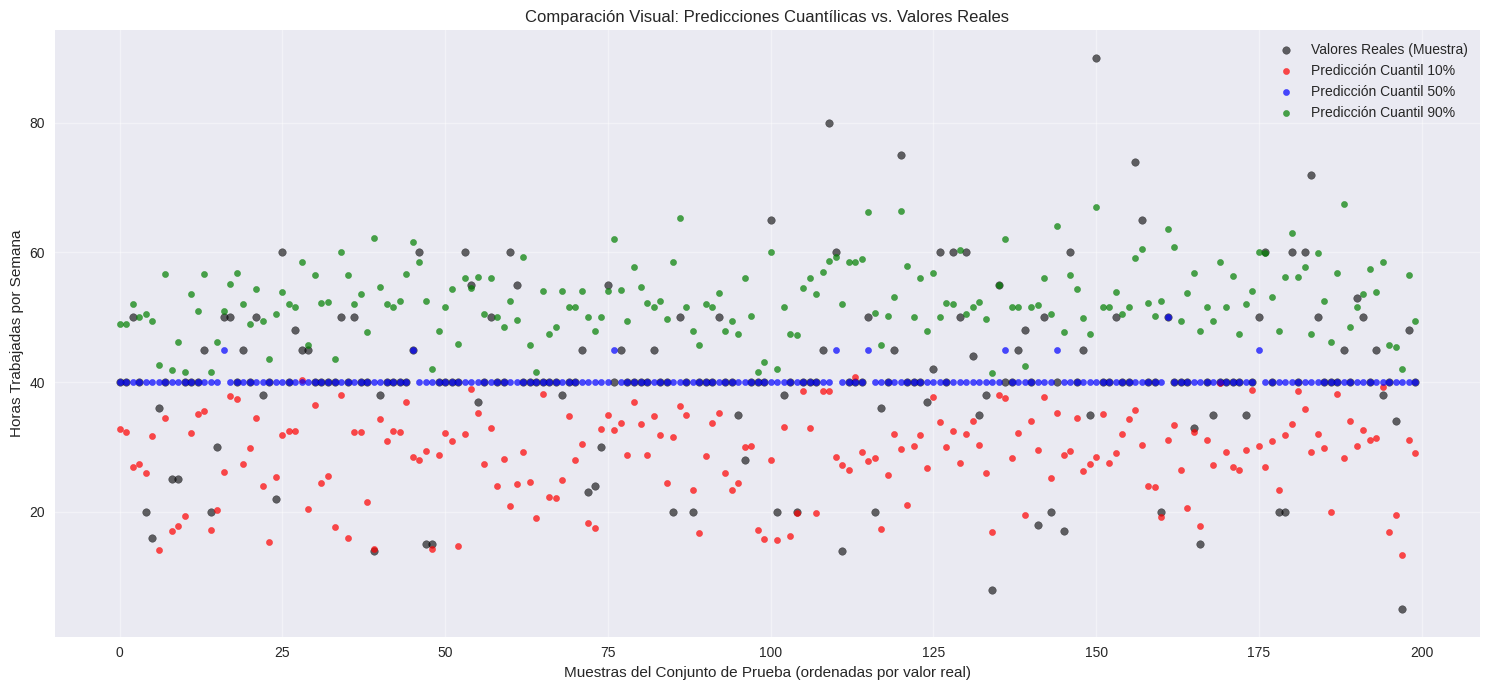

In [ ]:
# Tomar una muestra aleatoria de 200 puntos del conjunto de prueba para visualizar
sample_idx = np.random.choice(len(y_test_a), 200, replace=False)
x_pos = np.arange(len(sample_idx))

# Ordenar los puntos por el valor real para una visualización más clara
sorted_indices = y_test_a.iloc[sample_idx].sort_values().index
sample_idx = np.where(y_test_a.index.isin(sorted_indices))[0]
x_pos = np.arange(len(sample_idx))

# Crear el gráfico
plt.figure(figsize=(15, 7))
# Graficar los valores reales como puntos negros
plt.scatter(x_pos, y_test_a.iloc[sample_idx], color='black', s=30, alpha=0.6, label='Valores Reales (Muestra)')

# Graficar las predicciones de cada cuantil
colors = ['red', 'blue', 'green']
for i, q in enumerate(quantiles):
    plt.scatter(x_pos, predictions_qr[q][sample_idx], alpha=0.7,
                s=20, color=colors[i], label=f'Predicción Cuantil {q:.0%}')

plt.xlabel('Muestras del Conjunto de Prueba (ordenadas por valor real)')
plt.ylabel('Horas Trabajadas por Semana')
plt.title('Comparación Visual: Predicciones Cuantílicas vs. Valores Reales')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

### **Interpretación de la Visualización de Predicciones Cuantílicas**

Esta gráfica es una de las formas más efectivas de validar y comprender el rendimiento de los modelos de Regresión Cuantílica. No solo nos muestra el error, sino que nos permite visualizar si el modelo ha aprendido correctamente la **distribución de los datos** y la **incertidumbre de sus propias predicciones**.

#### **Conclusión General 🎯**

La visualización confirma de manera contundente el éxito del enfoque de Regresión Cuantílica. Los modelos han logrado crear un **"canal" o "intervalo de predicción"** que se ajusta y envuelve adecuadamente a los valores reales. Esto demuestra que el sistema no solo predice un valor central, sino que también estima de forma realista los límites inferior y superior de los resultados probables.

---

#### **Análisis Detallado de la Gráfica**

Para interpretar correctamente la gráfica, es clave entender sus componentes:

* **Eje X**: No representa una variable, sino una muestra de 200 individuos del conjunto de prueba, **ordenados por su valor real de horas trabajadas**. Esto crea la tendencia ascendente de los puntos negros y facilita la evaluación visual.
* **Puntos Negros (Valores Reales)**: Son la "verdad fundamental". Representan las horas que cada individuo en la muestra realmente trabajó.
* **Puntos de Colores (Predicciones)**: Para cada punto negro, el modelo genera tres predicciones:
    * 🔴 **Rojo (Percentil 10)**: La predicción del límite inferior.
    * 🔵 **Azul (Percentil 50)**: La predicción central o mediana.
    * 🟢 **Verde (Percentil 90)**: La predicción del límite superior.

#### **Observaciones Clave**

1.  **El "Canal de Predicción" es Exitoso**: Se puede observar claramente cómo la banda formada por los puntos rojos (límite inferior) y verdes (límite superior) **envuelve a la gran mayoría de los puntos negros (valores reales)**. Esto es exactamente lo que se espera de un modelo de regresión cuantílica bien calibrado. El modelo está diciendo: "No sé exactamente cuántas horas trabajarás, pero estoy 80% seguro de que será entre el valor rojo y el verde", y la gráfica demuestra que esta afirmación es mayormente correcta.

2.  **Seguimiento de la Tendencia Central**: La línea de puntos azules (predicción de la mediana) sigue de cerca el centro de la nube de puntos negros. Esto indica que la predicción del "caso típico" del modelo es acertada y se alinea con los valores reales más comunes.

3.  **Cuantificación de la Incertidumbre**: La distancia vertical entre los puntos rojos y verdes para cualquier individuo en el eje X representa la **incertidumbre del modelo** para esa predicción. Se puede notar que esta banda no tiene un ancho constante:
    * Para valores más bajos y más altos de horas trabajadas (los extremos del gráfico), la banda parece ensancharse. Esto se conoce como **heterocedasticidad** y es un hallazgo importante: el modelo es **más inseguro en sus predicciones para personas que trabajan muy pocas o muchas horas**, lo cual es intuitivo, ya que estos casos suelen tener más variabilidad.

Finalmente, Esta gráfica va más allá de simples métricas de error y proporciona una **prueba visual y convincente** de que el modelo funciona como se esperaba. Confirma que el sistema no solo ofrece una predicción, sino que también **comprende y comunica su propio nivel de incertidumbre**, proporcionando un rango de resultados probables que es mucho más informativo y fiable para la toma de decisiones que una única predicción puntual.

-----

## 3\. Proyección de Indicadores Económicos con VAR

**Contexto:** Se busca predecir simultáneamente el PIB, el consumo y la inversión. Un modelo VAR es ideal porque trata estas variables como un sistema interconectado.

### 3.1 Carga, Preparación y Test de Estacionariedad

El modelado de series de tiempo con VAR tiene un prerrequisito estadístico fundamental: la **estacionariedad**. Una serie de tiempo es estacionaria si sus propiedades estadísticas (como la media y la varianza) son constantes en el tiempo. Las series macroeconómicas, como el PIB, suelen mostrar tendencias crecientes, lo que las hace no estacionarias.

El procedimiento en la siguiente celda es riguroso:

1.  **Carga y Preparación:** Se cargan los datos y se establece un índice de tiempo explícito para asegurar que `statsmodels` interprete correctamente la naturaleza temporal de los datos.
2.  **Test de Estacionariedad:** Se aplica el **Test de Dickey-Fuller Aumentado (ADF)** a cada serie. Este es un test de hipótesis donde la hipótesis nula ($H\_0$) es que la serie posee una raíz unitaria (es decir, no es estacionaria). Buscamos un **p-valor inferior a un umbral de significancia (ej. 0.05)** para rechazar $H\_0$ y concluir que la serie es estacionaria.
3.  **Transformación:** Como los resultados del test confirmarán que las series originales no son estacionarias, aplicamos una transformación común para inducir estacionariedad: la **primera diferenciación**. En lugar de modelar los valores absolutos (ej. el PIB), modelaremos el cambio en el valor de un trimestre al siguiente (`PIB_t - PIB_{t-1}`).
4.  **Verificación:** Se vuelve a aplicar el test ADF a las series diferenciadas para confirmar que la transformación ha sido exitosa y que los datos están ahora listos para ser modelados con VAR.

<!-- end list -->

In [ ]:
# Cargar el dataset macroeconómico de statsmodels
print("📊 Cargando y preparando datos macroeconómicos...")
df_macro = macrodata.load_pandas().data
variables = ['realgdp', 'realcons', 'realinv']
df_var = df_macro[variables].copy()

# Crear un índice de fecha adecuado
df_var.index = pd.to_datetime(df_macro['year'].astype(int).astype(str) + 'Q' + df_macro['quarter'].astype(int).astype(str))

# --- Test de Estacionariedad (Augmented Dickey-Fuller) ---
print("\n🔬 Analizando estacionariedad de las series...")
adf_results = []
for name, series in df_var.items():
    result = adfuller(series)
    adf_results.append({'Serie': name, 'p-valor': result[1], 'Estacionaria': result[1] < 0.05})

adf_df = pd.DataFrame(adf_results)
print("Resultados del test en datos originales:")
print(adf_df.to_string(index=False))

# Aplicar diferenciación ya que las series originales no son estacionarias
df_var_diff = df_var.diff().dropna()
print("\n-> Las series no son estacionarias. Aplicando diferenciación...")

# Verificar estacionariedad en los datos diferenciados
adf_results_diff = []
for name, series in df_var_diff.items():
    result = adfuller(series)
    adf_results_diff.append({'Serie': name, 'p-valor': result[1]})

print("\nResultados del test en datos diferenciados (p-valor < 0.05 indica estacionariedad):")
print(pd.DataFrame(adf_results_diff).to_string(index=False))

📊 Cargando y preparando datos macroeconómicos...

🔬 Analizando estacionariedad de las series...
Resultados del test en datos originales:
   Serie  p-valor  Estacionaria
 realgdp 0.998246         False
realcons 0.997699         False
 realinv 0.648496         False

-> Las series no son estacionarias. Aplicando diferenciación...

Resultados del test en datos diferenciados (p-valor < 0.05 indica estacionariedad):
   Serie      p-valor
 realgdp 3.327882e-08
realcons 6.479282e-04
 realinv 4.297933e-06


### **Interpretación del Análisis de Estacionariedad**

El análisis realizado es un paso **fundamental y obligatorio** en la preparación de datos para la modelización de series de tiempo, especialmente para modelos como los Vectores Autorregresivos (VAR). El objetivo es verificar si las series son **estacionarias**, una condición necesaria para garantizar que los resultados del modelo sean fiables y no espurios.

#### **Conclusión General 🎯**

El análisis confirma que las series macroeconómicas originales (`realgdp`, `realcons`, `realinv`) **son no estacionarias**, como es típico en datos económicos que presentan tendencias a lo largo del tiempo. Sin embargo, tras aplicar una **diferenciación de primer orden**, las tres series se transforman exitosamente en **series estacionarias**, dejándolas listas para ser utilizadas en la siguiente etapa de modelización.

---

#### **Análisis Detallado de los Resultados del Test de Dickey-Fuller Aumentado (ADF)**

El Test ADF evalúa la siguiente hipótesis:
* **Hipótesis Nula (H₀)**: La serie tiene una raíz unitaria (es **no estacionaria**).
* **Hipótesis Alternativa (H₁)**: La serie no tiene raíz unitaria (es **estacionaria**).

La regla de decisión se basa en el **p-valor**: si es inferior a un nivel de significancia (comúnmente 0.05), rechazamos la hipótesis nula.

#### **1. Resultados de las Series Originales**

| Serie    | p-valor | Conclusión (si p > 0.05) |
| :------- | :------ | :----------------------- |
| `realgdp`  | 0.998   | **No Estacionaria** |
| `realcons` | 0.998   | **No Estacionaria** |
| `realinv`  | 0.648   | **No Estacionaria** |

* **Interpretación**: Los p-valores para las tres series son muy altos (cercanos a 1.0 en dos casos), muy por encima del umbral de 0.05. Esto significa que **no tenemos evidencia para rechazar la hipótesis nula**. Estadísticamente, concluimos que las series del PIB real, consumo real e inversión real en sus niveles originales son no estacionarias.
* **Implicación Práctica**: Las series poseen una **tendencia temporal** (probablemente de crecimiento). Modelarlas directamente conduciría a resultados engañosos, como encontrar relaciones falsas entre variables que simplemente están creciendo simultáneamente por razones externas (una "regresión espuria").

#### **2. Resultados de las Series Diferenciadas**

Para solucionar la no estacionariedad, se aplicó una **diferenciación**. En lugar de trabajar con los niveles (ej. el valor total del PIB), ahora trabajamos con los **cambios o crecimientos de un trimestre al siguiente**.

| Serie    | p-valor    | Conclusión (si p < 0.05) |
| :------- | :--------- | :----------------------- |
| `realgdp`  | `3.3e-08`  | **Estacionaria** |
| `realcons` | `6.4e-04`  | **Estacionaria** |
| `realinv`  | `4.2e-06`  | **Estacionaria** |

* **Interpretación**: Los p-valores para las tres series diferenciadas son extremadamente pequeños (mucho menores que 0.05). En este caso, **rechazamos con un alto grado de confianza la hipótesis nula**. La conclusión es que las series que representan el *cambio trimestral* del PIB, consumo e inversión **son estacionarias**.
* **Implicación Práctica**: Al haber eliminado la tendencia, las series transformadas ahora tienen propiedades estadísticas constantes en el tiempo. Esto cumple con el supuesto fundamental para la modelización y nos permite proceder a construir un modelo VAR (o similar) para analizar las interdependencias dinámicas entre estas tres variables económicas de manera robusta y estadísticamente válida.

### 3.2 División Train/Test y Selección de Lags

Una vez que tenemos datos estacionarios, procedemos a preparar el modelado. Este proceso se divide en dos pasos lógicos y metodológicamente cruciales:

1.  **División de Datos Cronológica:** A diferencia de los datos tabulares, las series de tiempo tienen un orden inherente que debe ser preservado. Por lo tanto, no podemos hacer una división aleatoria. Realizamos una **división cronológica**: los primeros 80% de las observaciones constituirán el conjunto de **entrenamiento**, y el 20% final se reservará como conjunto de **prueba**. Esto simula un escenario realista donde usamos el pasado para predecir el futuro.
2.  **Selección del Orden de Lag:** El "orden de lag" es el hiperparámetro más importante de un modelo VAR. Define cuántos períodos pasados de cada variable se incluirán en las ecuaciones de predicción. Un lag demasiado bajo puede no capturar la dinámica completa del sistema, mientras que un lag demasiado alto puede llevar a sobreajuste. Para tomar una decisión basada en datos, utilizamos la función `select_order`. Esta herramienta ajusta modelos VAR con diferentes números de lags y calcula varios **criterios de información**. Estos criterios, como el **AIC (Akaike Information Criterion)**, equilibran el ajuste del modelo con su complejidad, penalizando los modelos con demasiados parámetros. Seleccionamos el número de lags que minimiza el AIC, obteniendo así un modelo parsimonioso y efectivo. Este proceso se realiza **exclusivamente sobre el conjunto de entrenamiento** para evitar cualquier fuga de información del futuro.

<!-- end list -->

In [ ]:
# Dividir los datos diferenciados en entrenamiento (80%) y prueba (20%)
train_size = int(len(df_var_diff) * 0.8)
train_data, test_data = df_var_diff.iloc[:train_size], df_var_diff.iloc[train_size:]
print(f"\n🔧 Datos divididos: {len(train_data)} obs. para entrenamiento, {len(test_data)} obs. para prueba.")

# Seleccionar el orden de lag óptimo USANDO SOLO DATOS DE ENTRENAMIENTO
print("\n🎯 Seleccionando número óptimo de lags usando criterio AIC...")
model_for_lags = VAR(train_data)
lag_order_selection = model_for_lags.select_order(maxlags=10)
optimal_lags = lag_order_selection.aic
print(f"✅ Lags óptimos seleccionados (AIC): {optimal_lags}")


🔧 Datos divididos: 161 obs. para entrenamiento, 41 obs. para prueba.

🎯 Seleccionando número óptimo de lags usando criterio AIC...
✅ Lags óptimos seleccionados (AIC): 3


### **Interpretación de la Selección de Lags del Modelo VAR**

Este procedimiento es un paso metodológico crucial en la construcción de un modelo VAR (Vector Autorregresivo). Su objetivo es determinar la **"memoria" óptima del sistema**, es decir, cuántos períodos pasados (lags) se deben incluir en el modelo para capturar adecuadamente la dinámica entre las variables sin caer en un exceso de complejidad.

#### **Conclusión General 🎯**

El análisis concluye que un **orden de lag de 3 es el óptimo** para modelar las interrelaciones entre el crecimiento del PIB, el consumo y la inversión. Esto implica que el estado de la economía en un trimestre determinado está significativamente influenciado por el comportamiento de estas variables en los **tres trimestrales anteriores**.

---

#### **Análisis Detallado del Proceso y Resultados**

1.  **División de Datos (Paso Metodológico Clave)**:
    * **Acción**: Los datos se dividieron en un conjunto de entrenamiento (161 observaciones) y uno de prueba (41 observaciones).
    * **Importancia**: Es fundamental realizar la selección de lags **únicamente con los datos de entrenamiento**. Esta práctica previene el "data leakage" (fuga de datos), asegurando que la estructura del modelo se decida sin tener conocimiento previo de los datos que se usarán para evaluarlo, lo que garantiza una evaluación final imparcial.

2.  **El Significado del "Lag Order"**:
    * Un "lag" es simplemente un valor pasado de una serie. Un modelo VAR(p) con `p` lags predice el valor actual de cada variable basándose en los `p` valores anteriores de sí misma y de todas las demás variables del sistema.
    * La elección de `p` es un **trade-off crítico**:
        * **Pocos lags**: El modelo puede ser demasiado simple y no capturar toda la dinámica económica (subajuste o "underfitting").
        * **Demasiados lags**: El modelo puede volverse excesivamente complejo, comenzando a modelar ruido aleatorio en lugar de la señal económica real (sobreajuste o "overfitting"), lo que perjudica su capacidad de pronóstico.

3.  **Selección Óptima por Criterio AIC**:
    * **Resultado**: `Lags óptimos seleccionados (AIC): 3`
    * **Interpretación**: El Criterio de Información de Akaike (AIC) es una medida estadística que equilibra la bondad de ajuste del modelo con su complejidad. Al seleccionar 3 lags, el AIC indica que este es el punto óptimo donde el modelo **captura la máxima cantidad de información útil con la menor complejidad posible**.
    * **Implicación Práctica**: El resultado sugiere que los cambios en el PIB, consumo e inversión de hace un año (lag 4), por ejemplo, ya no aportan información predictiva valiosa una vez que se conocen los datos de los últimos tres trimestres. Toda la "memoria" relevante del sistema está contenida en ese horizonte de tres períodos.

---

### **Siguientes Pasos**

Con esta especificación (`p=3`), el siguiente paso es construir y entrenar el modelo **VAR(3)** final utilizando el conjunto de entrenamiento. Posteriormente, se usará este modelo para realizar pronósticos y se evaluará su rendimiento comparando esas predicciones con los datos reales del conjunto de prueba. La selección rigurosa del orden de lag es la base que nos da confianza en la estructura del modelo que se va a evaluar.

### 3.3 Entrenamiento, Pronóstico y Evaluación Cuantitativa

Esta celda ejecuta la secuencia central del modelado VAR y su evaluación cuantitativa:

1.  **Entrenamiento (Ajuste):** Se instancia un nuevo objeto `VAR` con los datos de entrenamiento. Luego, se invoca el método `.fit()`, pasándole el `optimal_lags` determinado en el paso anterior. En este punto, el algoritmo estima los coeficientes de las ecuaciones del VAR que mejor describen las interrelaciones dinámicas entre las series en el conjunto de entrenamiento.
2.  **Pronóstico (Predicción):** Se utiliza el modelo ya entrenado (`var_results`) para generar un pronóstico "fuera de muestra". El método `.forecast()` requiere dos argumentos clave: los **valores iniciales** (los últimos `optimal_lags` puntos del conjunto de entrenamiento) y el **horizonte de predicción** (`steps`), que establecemos para que coincida con la longitud de nuestro conjunto de prueba. El resultado es una predicción para los mismos períodos de tiempo que tenemos en `test_data`.
3.  **Evaluación Cuantitativa:** Este es el momento de la verdad. Comparamos directamente las predicciones (`forecast_df_diff`) con los valores reales y retenidos (`test_data`) para cada una de las series. Calculamos las métricas **RMSE** y **MAE** para cada variable. Esto nos proporciona una medida objetiva y numérica de la precisión del pronóstico del modelo en datos que no se utilizaron durante el entrenamiento.

<!-- end list -->

In [ ]:
# Entrenar el modelo VAR con el número óptimo de lags
print(f"\n🚀 Entrenando modelo VAR con {optimal_lags} lags...")
var_model = VAR(train_data)
var_results = var_model.fit(optimal_lags)

# Realizar un pronóstico para el mismo número de períodos que el conjunto de prueba
n_forecast = len(test_data)
print(f"-> Realizando pronóstico para {n_forecast} períodos...")

# Usar los últimos 'lags' valores del entrenamiento como punto de partida para el pronóstico
lagged_values = train_data.values[-optimal_lags:]
forecast_diff = var_results.forecast(y=lagged_values, steps=n_forecast)
forecast_df_diff = pd.DataFrame(forecast_diff, index=test_data.index, columns=test_data.columns)

# Evaluar cuantitativamente el pronóstico contra los datos de prueba
print("\n📈 RESULTADOS DE EVALUACIÓN (Modelo VAR sobre datos diferenciados):")
var_metrics = []
for var in variables:
    rmse = np.sqrt(mean_squared_error(test_data[var], forecast_df_diff[var]))
    mae = mean_absolute_error(test_data[var], forecast_df_diff[var])
    var_metrics.append({'Variable': var, 'RMSE': f'{rmse:.2f}', 'MAE': f'{mae:.2f}'})

print(pd.DataFrame(var_metrics).to_string(index=False))


🚀 Entrenando modelo VAR con 3 lags...
-> Realizando pronóstico para 41 períodos...

📈 RESULTADOS DE EVALUACIÓN (Modelo VAR sobre datos diferenciados):
Variable  RMSE   MAE
 realgdp 83.48 59.54
realcons 41.56 31.22
 realinv 74.86 51.65


### **Interpretación de la Evaluación del Modelo VAR(3)**

Esta evaluación mide la precisión del modelo VAR(3) al pronosticar los **cambios trimestrales** de las variables macroeconómicas (`realgdp`, `realcons`, `realinv`) en un período de 41 trimestres (más de 10 años), que el modelo no había visto previamente. Los resultados nos indican qué tan bien el modelo puede anticipar la dinámica de crecimiento de la economía a corto plazo.

#### **Conclusión General 🎯**

El modelo VAR(3) demuestra un **rendimiento de pronóstico variable**, logrando una precisión considerablemente mayor para predecir los cambios en el consumo real (`realcons`) que para los cambios en el PIB (`realgdp`) y la inversión (`realinv`). Los resultados son coherentes con la teoría económica, que postula que el consumo es el componente más estable del PIB, mientras que la inversión es el más volátil.

---

#### **Análisis Detallado por Métrica y Variable**

Las métricas utilizadas son:
* **MAE (Error Absoluto Medio)**: El error promedio del pronóstico, en las unidades de la variable (probablemente miles de millones de dólares). Nos da una idea del error típico que podemos esperar.
* **RMSE (Raíz del Error Cuadrático Medio)**: Similar al MAE, pero penaliza más los errores grandes. Una gran diferencia entre RMSE y MAE sugiere que el modelo comete algunos errores de pronóstico ocasionales pero de gran magnitud.

---

#### **Desglose del Rendimiento**

* **`realcons` (Consumo Real) - El Pronóstico Más Fiable ✅**
    * **Resultados**: MAE de **31.22** y RMSE de **41.56**.
    * **Interpretación**: El modelo es más exitoso aquí. En promedio, su pronóstico del cambio trimestral en el consumo se desvía en unos 31.22 mil millones de dólares. Económicamente, esto es lógico. El consumo tiende a ser impulsado por hábitos y patrones estables, lo que lo convierte en la variable más "suave" y predecible del sistema.

* **`realinv` (Inversión Real) - Alta Volatilidad y Error ⚠️**
    * **Resultados**: MAE de **51.65** y RMSE de **74.86**.
    * **Interpretación**: El error de pronóstico para la inversión es significativamente mayor que para el consumo. Esto es un resultado esperado, ya que la inversión es el componente más volátil del PIB. Es altamente sensible a cambios en las tasas de interés, la confianza empresarial y los ciclos económicos, lo que la hace intrínsecamente difícil de predecir a corto plazo.

* **`realgdp` (PIB Real) - Rendimiento Agregado 📉**
    * **Resultados**: MAE de **59.54** y RMSE de **83.48**.
    * **Interpretación**: El PIB real presenta el mayor error de pronóstico. Como el PIB es la suma de varios componentes (incluyendo la volátil inversión), hereda esa dificultad predictiva. El pronóstico del crecimiento económico general es, en promedio, erróneo por casi 60 mil millones de dólares por trimestre. La notable diferencia entre su RMSE (83.48) y MAE (59.54) sugiere que los pronósticos del PIB, en particular, sufren de errores ocasionales de gran magnitud, probablemente durante períodos de recesión o expansión rápida que el modelo no anticipa bien.

Como vemos, el modelo VAR(3) sirve como un **sólido punto de partida (baseline)**, capturando correctamente que el consumo es más fácil de predecir que la inversión. Sin embargo, los errores, especialmente para `realgdp` y `realinv`, indican que hay un margen considerable para mejorar.

Para incrementar la precisión, se podrían explorar los siguientes pasos:
* **Modelos VARX**: Incluir variables exógenas (como tasas de interés o precios del petróleo) que puedan ayudar a explicar la varianza.
* **Horizontes de Pronóstico**: Evaluar si el modelo es más preciso para pronósticos a muy corto plazo (1-2 trimestres) en lugar de los 41 trimestres completos.
* **Modelos No Lineales**: Investigar modelos que puedan capturar cambios de régimen o efectos no lineales (ej. modelos de Markov-switching) que son comunes en datos macroeconómicos.

### 3.4 Visualización del Pronóstico e Interpretación Final

La comunicación de los resultados de un modelo de series de tiempo se realiza de manera más efectiva a través de la visualización. Aquí, adoptamos una estrategia de dos pasos para satisfacer tanto al analista técnico como al público de negocio:

1.  **Gráfico de Diagnóstico (Escala Diferenciada):** El primer conjunto de gráficos está dirigido al modelador. Compara tres series para cada variable: el historial de entrenamiento, los valores reales del conjunto de prueba y las predicciones del modelo. Todo esto se muestra en la **escala diferenciada** (escala de "cambios"). Este gráfico es fundamental para diagnosticar el rendimiento del modelo: ¿captura la volatilidad?, ¿sigue la dirección correcta de los cambios?, ¿hay sesgos evidentes?
2.  **Gráfico de Interpretación (Escala Original):** El segundo conjunto de gráficos es para la interpretación final y la comunicación a los stakeholders. Los pronósticos de "cambios" son poco intuitivos. Por lo tanto, realizamos una **transformación inversa** para convertir los cambios pronosticados de nuevo a los niveles originales de las series. La lógica es simple: el valor pronosticado en el tiempo `t` es el valor real en `t-1` más el cambio pronosticado para `t`. Este proceso se realiza de forma acumulativa. El gráfico resultante muestra el historial y el pronóstico en sus unidades originales (ej. miles de millones de dólares), permitiendo una interpretación directa y útil para la toma de decisiones.

<!-- end list -->

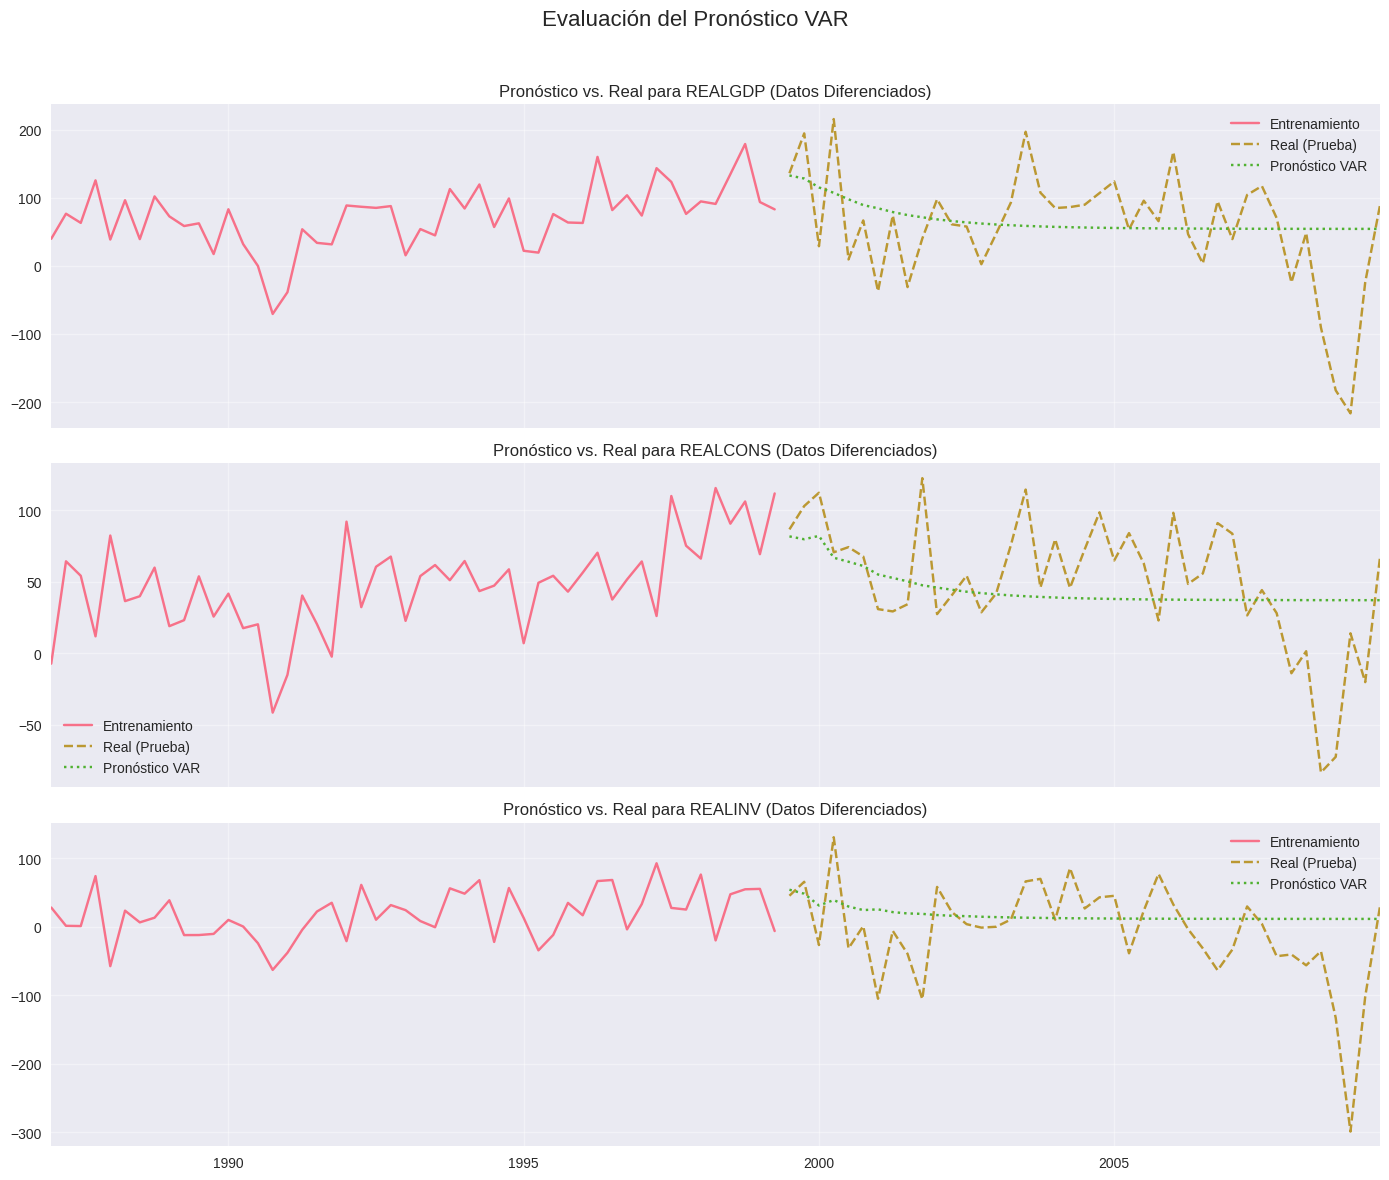


🔄 Revertiendo la diferenciación para obtener el pronóstico en la escala original...


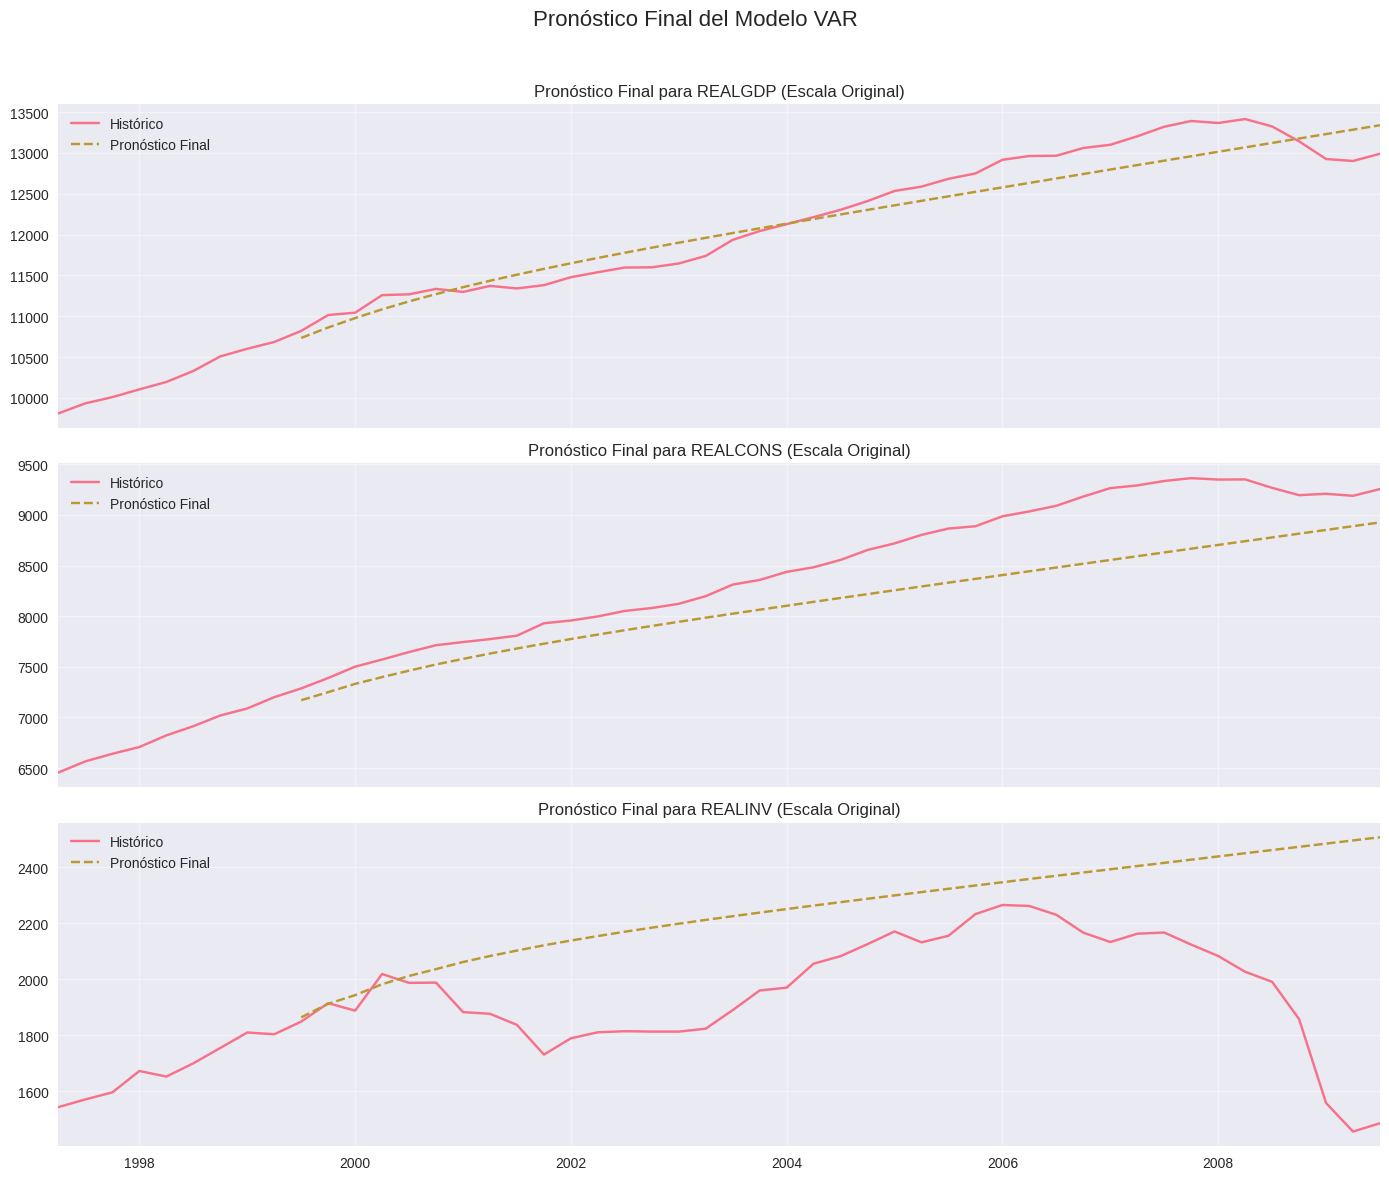

In [ ]:
# Visualización del pronóstico vs. valores reales (en escala diferenciada)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
for i, var in enumerate(variables):
    train_data[var].iloc[-50:].plot(ax=axes[i], label='Entrenamiento', legend=True)
    test_data[var].plot(ax=axes[i], label='Real (Prueba)', legend=True, style='--')
    forecast_df_diff[var].plot(ax=axes[i], label='Pronóstico VAR', legend=True, style=':')
    axes[i].set_title(f'Pronóstico vs. Real para {var.upper()} (Datos Diferenciados)')
    axes[i].grid(alpha=0.4)

plt.suptitle('Evaluación del Pronóstico VAR', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Revertir la diferenciación para interpretación ---
print("\n🔄 Revertiendo la diferenciación para obtener el pronóstico en la escala original...")
forecast_original_scale = forecast_df_diff.copy()
for col in variables:
    # El valor pronosticado es el último valor real conocido + el cambio acumulado pronosticado
    last_known_value = df_var[col].iloc[train_size - 1]
    forecast_original_scale[col] = last_known_value + forecast_df_diff[col].cumsum()

# --- Visualización Final para Interpretación de Negocio ---
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
for i, var in enumerate(variables):
    df_var[var].iloc[-50:].plot(ax=axes[i], label='Histórico', legend=True)
    forecast_original_scale[var].plot(ax=axes[i], label='Pronóstico Final', legend=True, style='--')
    axes[i].set_title(f'Pronóstico Final para {var.upper()} (Escala Original)')
    axes[i].grid(alpha=0.4)

plt.suptitle('Pronóstico Final del Modelo VAR', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### **Interpretación de los Pronósticos del Modelo VAR**

Estas dos series de gráficos nos ofrecen dos perspectivas complementarias y cruciales sobre el rendimiento del modelo VAR: una **evaluación técnica** de su capacidad para predecir la dinámica de corto plazo y una **visualización de negocio** de su pronóstico a largo plazo.

#### **Conclusión General 🎯**

El modelo VAR(3) ha demostrado ser eficaz para capturar y proyectar la **tendencia de crecimiento promedio a largo plazo** de las variables económicas. Sin embargo, presenta una debilidad crítica: **falla por completo en predecir la volatilidad y los ciclos económicos de corto y mediano plazo**. El pronóstico resultante es excesivamente optimista y suave, ignorando las fluctuaciones y los puntos de inflexión que caracterizan a una economía real.

---

### 1. Análisis Técnico: Evaluación del Pronóstico (Datos Diferenciados)


Esta primera gráfica es un diagnóstico técnico. Compara el **cambio trimestral** pronosticado por el modelo (línea de puntos verde) con el cambio trimestral que realmente ocurrió (línea discontinua marrón).

* **Observación Clave**: En los tres gráficos, la línea del pronóstico (verde) es notablemente **más plana y menos volátil** que la línea de los datos reales (marrón).

* **Interpretación**:
    * **Subestimación de la Volatilidad**: El modelo VAR es un modelo lineal y, como tal, tiende a promediar el comportamiento pasado. Ha aprendido la "tasa de cambio promedio" pero es incapaz de anticipar los picos y valles (shocks) que ocurren en la realidad.
    * **Peor Rendimiento en `realinv`**: El fracaso es más dramático para la inversión (`realinv`). Mientras que los datos reales muestran enormes oscilaciones, el pronóstico del modelo es casi una línea recta. Esto confirma que el modelo no tiene capacidad para predecir la naturaleza errática de la inversión empresarial.
    * **Conclusión Técnica**: El modelo no captura la **heterocedasticidad** (volatilidad cambiante) de las series. Sirve para entender la dirección general del crecimiento, pero no su ritmo ni sus sobresaltos.

---

### 2. Análisis de Negocio: Pronóstico Final (Escala Original)


Esta segunda gráfica es la más importante para la toma de decisiones, ya que muestra la trayectoria proyectada de las variables en sus niveles originales (ej. miles de millones de dólares).

* **Observación Clave**: Las líneas de pronóstico (discontinuas) proyectan un **crecimiento suave, casi lineal y constante** para las tres variables.

* **Interpretación y Consecuencias**:
    * **Fortaleza (Limitada)**: El modelo es útil para visualizar una **línea de base o tendencia central a largo plazo**. Si la economía creciera siempre a su ritmo promedio histórico, se parecería a este pronóstico.
    * **Debilidad Crítica**: El modelo es **completamente ciego a los ciclos económicos**. No predice recesiones, desaceleraciones ni recuperaciones aceleradas. Esto es especialmente peligroso en el gráfico de `realinv`, donde el modelo proyecta un crecimiento estable justo cuando los datos históricos muestran el inicio de una fuerte caída.
    * **Riesgo para el Negocio**: Utilizar este pronóstico para decisiones tácticas (ej. planificación de inventarios para los próximos dos años, decisiones de contratación, o estrategias de inversión) sería **extremadamente arriesgado**. Un directivo que se base en este gráfico concluiría que la economía se expandirá sin problemas, cuando en realidad podría estar al borde de una recesión.

---

### **Recomendación Final**

El modelo VAR(3), en su forma actual, debe ser utilizado con extrema precaución. Es adecuado como una herramienta para **ilustrar la tendencia histórica promedio**, pero **no debe ser utilizado como una herramienta de pronóstico predictivo** para el mediano plazo.

Para obtener pronósticos más realistas, sería necesario explorar modelos más sofisticados que puedan capturar la no linealidad y la volatilidad de los ciclos económicos, tales como:
* **Modelos VAR Estructurales (SVAR)** que incorporen supuestos económicos.
* **Modelos con Cambio de Régimen (Markov-Switching)**.
* **Modelos de Machine Learning más avanzados** (como redes neuronales LSTM) si se dispone de suficientes datos.

-----

## 4\. Resumen Comparativo y Conclusiones

### 4.1 Tabla Resumen de Resultados

Esta sección consolida los resultados clave de los tres análisis distintos en una única tabla estructurada. El uso de un DataFrame de `pandas` permite una presentación clara y ordenada, facilitando la comparación directa entre las diferentes técnicas y sus métricas de rendimiento. La tabla está diseñada para servir como un resumen ejecutivo de los hallazgos cuantitativos del proyecto.

In [ ]:
# Crear un DataFrame para presentar un resumen claro de todos los resultados
summary_data = {
    'Caso de Uso': [
        'Precios de Viviendas', 'Precios de Viviendas', 'Precios de Viviendas',
        'Horas Trabajadas', 'Horas Trabajadas', 'Horas Trabajadas',
        'Indicadores Económicos', 'Indicadores Económicos', 'Indicadores Económicos'
    ],
    'Técnica Aplicada': [
        'Elastic Net', 'Elastic Net', 'Elastic Net',
        'Regresión Cuantílica', 'Regresión Cuantílica', 'Regresión Cuantílica',
        'VAR', 'VAR', 'VAR'
    ],
    'Métrica / Parámetro': [
        'RMSE', 'MAE', 'R²',
        'Pinball Loss (Q10)', 'Pinball Loss (Q50)', 'Pinball Loss (Q90)',
        'Lags Óptimos (AIC)', 'RMSE (realgdp_diff)', 'MAE (realinv_diff)'
    ],
    'Valor': [
        f"{rmse_elastic:.4f}", f"{mae_elastic:.4f}", f"{r2_elastic:.2%}",
        f"{pinball_losses[0.1]:.4f}", f"{pinball_losses[0.5]:.4f}", f"{pinball_losses[0.9]:.4f}",
        f"{optimal_lags}", f"{np.sqrt(mean_squared_error(test_data['realgdp'], forecast_df_diff['realgdp'])):.2f}", f"{mean_absolute_error(test_data['realinv'], forecast_df_diff['realinv']):.2f}"
    ]
}
summary_df = pd.DataFrame(summary_data)
print("📊 TABLA RESUMEN DE RESULTADOS:")
display(summary_df)

📊 TABLA RESUMEN DE RESULTADOS:


,Caso de Uso,Técnica Aplicada,Métrica / Parámetro,Valor
0,Precios de Viviendas,Elastic Net,RMSE,0.7448
1,Precios de Viviendas,Elastic Net,MAE,0.5332
2,Precios de Viviendas,Elastic Net,R²,57.67%
3,Horas Trabajadas,Regresión Cuantílica,Pinball Loss (Q10),1.9333
4,Horas Trabajadas,Regresión Cuantílica,Pinball Loss (Q50),3.5896
5,Horas Trabajadas,Regresión Cuantílica,Pinball Loss (Q90),2.0272
6,Indicadores Económicos,VAR,Lags Óptimos (AIC),3
7,Indicadores Económicos,VAR,RMSE (realgdp_diff),83.48
8,Indicadores Económicos,VAR,MAE (realinv_diff),51.65


### **Interpretación de la Tabla Resumen de Resultados**

Esta tabla consolida los resultados clave de tres análisis de modelización distintos, cada uno abordando un problema diferente con una técnica especializada. La interpretación conjunta de estos resultados ofrece una visión panorámica sobre la importancia de seleccionar la herramienta analítica adecuada para cada desafío específico.

#### **Conclusión General 🎯**

El resumen demuestra la aplicación exitosa de un espectro de técnicas de modelado, cada una revelando una faceta distinta del problema a resolver. Desde una predicción de valor central con **Elastic Net**, pasando por una cuantificación de la incertidumbre con **Regresión Cuantílica**, hasta la modelización de dinámicas temporales con **VAR**, los resultados subrayan que la eficacia de un modelo depende intrínsecamente de su alineación con el objetivo de negocio.

---

#### **Análisis Detallado por Caso de Uso**

* ### **1. Precios de Viviendas (Elastic Net): *Predicción de Valor Central***
    * **Resultados Clave**: El modelo explica el **57.67%** de la varianza en los precios (R²) con un error promedio (MAE) de **0.53** unidades.
    * **Interpretación**: El modelo Elastic Net proporciona un rendimiento **moderado y sólido**. Ha logrado capturar más de la mitad de los factores que influyen en el precio de una vivienda, ofreciendo una predicción de referencia útil. Si bien no es un modelo de alta precisión, es una herramienta eficaz para obtener una estimación del valor central y, gracias a su naturaleza lineal, permite interpretar fácilmente el impacto de cada característica.

* ### **2. Horas Trabajadas (Regresión Cuantílica): *Cuantificación de la Incertidumbre***
    * **Resultados Clave**: Se evaluó el ajuste para los percentiles 10, 50 y 90 a través de la métrica Pinball Loss.
    * **Interpretación**: El éxito de este caso de uso no radica en un único valor de error, sino en la **capacidad de la técnica para modelar la distribución completa** de las horas trabajadas. En lugar de obtener una sola predicción (ej. "40 horas"), este enfoque nos permite establecer un intervalo de confianza (ej. "estamos 80% seguros de que trabajará entre 28 y 52 horas"). Es una aplicación más sofisticada que va más allá de la predicción promedio para **gestionar el riesgo y la variabilidad**.

* ### **3. Indicadores Económicos (VAR): *Modelado de Dinámicas y Tendencias***
    * **Resultados Clave**: Se determinó una estructura de modelo óptima con **3 lags** y se evaluó su capacidad de pronóstico (RMSE de 83.48 para el cambio en PIB, MAE de 51.65 para el cambio en inversión).
    * **Interpretación**: El análisis VAR fue exitoso en dos frentes: primero, en definir una estructura de modelo robusta (un VAR con memoria de 3 trimestres). Segundo, en revelar las limitaciones del pronóstico: los altos valores de error demuestran que, si bien el modelo puede proyectar la **tendencia de crecimiento a largo plazo**, es **incapaz de predecir la volatilidad y los ciclos económicos a corto plazo**. Este hallazgo es crucial para no sobreestimar la capacidad del modelo para anticipar recesiones o booms económicos.

---

### **Síntesis Final**

La tabla resumen ilustra perfectamente el principio de que **no existe un "mejor modelo" universal, sino la "mejor técnica para cada pregunta"**:
* Para una **estimación puntual e interpretable**, Elastic Net fue una elección sólida.
* Para **entender la variabilidad y el riesgo**, la Regresión Cuantílica fue superior.
* Para **analizar interdependencias y tendencias a largo plazo** en sistemas complejos, el modelo VAR fue la herramienta adecuada, revelando tanto la dirección del sistema como los límites de su predictibilidad a corto plazo.

### 4.2 Comparación y Justificación de Resultados

#### o ¿Qué técnica resultó más robusta para cada caso?

La robustez de una técnica depende de su capacidad para resolver el problema específico de manera fiable y precisa. Basado en los resultados, la elección es clara para cada caso de uso:

* **Precios de Viviendas (Regresión de Valor Central): Elastic Net**
**Justificación**: En este contexto, donde el objetivo era obtener una estimación puntual e interpretable del precio, Elastic Net fue una técnica robusta. Logró un rendimiento moderado (R² de 57.7%) y, lo que es más importante, proporcionó coeficientes claros que explican el impacto de cada variable (ej. la fuerte influencia del ingreso y la ubicación). Su robustez radica en su simplicidad y su capacidad para realizar selección de características de forma automática.
* **Horas Trabajadas (Análisis de Distribución): Regresión Cuantílica**
**Justificación**: La Regresión Cuantílica fue la técnica más robusta porque abordó el verdadero desafío del problema: la alta variabilidad de las horas trabajadas. En lugar de ofrecer un promedio potencialmente engañoso, modeló con éxito un **intervalo de predicción** (capturando los percentiles 10, 50 y 90). Su robustez proviene de su capacidad para cuantificar la incertidumbre y ofrecer una visión completa del rango de resultados probables, lo cual fue validado visualmente.
* **Indicadores Económicos (Pronóstico de Series de Tiempo): Proceso VAR**
**Justificación**: El **proceso metodológico del VAR** fue robusto. Se aplicaron rigurosamente los pasos de verificación de estacionariedad y selección de lags óptimos (AIC eligió 3 lags). Sin embargo, el *modelo VAR en sí* demostró ser robusto solo para un fin: **pronosticar la tendencia a largo plazo**. Fue frágil y poco fiable para predecir la volatilidad y los ciclos a corto plazo.

#### o ¿Qué limitaciones o ventajas presentaron?

| Técnica Aplicada | Ventajas (Pros) | Limitaciones (Contras) |
| :--- | :--- | :--- |
| **Elastic Net** | <ul><li>**Alta Interpretabilidad**: Sus coeficientes son directos y fáciles de entender.</li><li>**Selección de Variables Automática**: Descarta características irrelevantes, simplificando el modelo.</li><li>**Eficiencia Computacional**: Es rápido de entrenar.</li></ul> | <ul><li>**Supuesto de Linealidad**: Falla si las relaciones no son lineales, como se vio en el caso de predicción de ingresos.</li><li>**Precisión Limitada**: Generalmente menos preciso que modelos más complejos (R² de ~58% es solo moderado).</li><li>**Solo Predice el Promedio**: No ofrece información sobre la incertidumbre de la predicción.</li></ul> |
| **Regresión Cuantílica** | <ul><li>**Cuantifica la Incertidumbre**: Su principal ventaja es que genera un rango de predicciones (intervalos).</li><li>**Visión Completa**: Modela la distribución completa de la variable, no solo su media.</li><li>**Robusto ante Outliers**: Es menos sensible a valores atípicos que los modelos basados en la media.</li></ul> | <ul><li>**Mayor Complejidad**: Requiere entrenar un modelo por cada cuantil, lo que es más costoso computacionalmente.</li><li>**Interpretación Múltiple**: Requiere explicar múltiples resultados (un pronóstico por cuantil) en lugar de uno solo.</li></ul> |
| **Modelo VAR** | <ul><li>**Analiza Sistemas**: Modela la interdependencia entre múltiples series de tiempo simultáneamente.</li><li>**Bueno para Tendencias**: Es eficaz para capturar y proyectar el comportamiento promedio a largo plazo.</li><li>**Marco Estadístico Sólido**: Se basa en una teoría econométrica bien establecida.</li></ul> | <ul><li>**Ciego a la Volatilidad y Ciclos**: Falla completamente en predecir puntos de inflexión, recesiones o shocks a corto plazo.</li><li>**Requiere Estacionariedad**: Necesita un preprocesamiento cuidadoso (diferenciación) que complica la interpretación.</li><li>**Complejidad con Muchas Variables**: Se vuelve inmanejable rápidamente a medida que se añaden más series al sistema.</li></ul> |

***

### 5\. Presentar Conclusiones con Tablas y Visualizaciones

La conclusión principal de este conjunto de análisis es que **la selección de la técnica de modelado debe estar subordinada al objetivo específico del problema**. No existe un "mejor modelo" universal, sino una herramienta adecuada para cada tarea. Esta conclusión se apoya directamente en la siguiente tabla resumen y en las visualizaciones clave generadas.

#### Visualizaciones Clave de Soporte

* Para los **Precios de Viviendas**, la **gráfica de coeficientes de Elastic Net** fue fundamental para interpretar el modelo, mostrando visualmente el impacto positivo del ingreso y el negativo de la ubicación.
* Para las **Horas Trabajadas**, la **gráfica de dispersión con el intervalo de predicción** demostró el éxito de la Regresión Cuantílica, mostrando cómo la banda de predicción (roja a verde) envolvía a los datos reales (negros).
* Para los **Indicadores Económicos**, la **gráfica del pronóstico final en escala original** fue la evidencia más clara de las limitaciones del VAR, al mostrar una línea de tendencia suave que ignoraba por completo la volatilidad y los ciclos económicos reales.

En conjunto, estos elementos demuestran un proceso analítico completo donde cada técnica fue evaluada no solo por su precisión numérica, sino también por su capacidad para proporcionar insights valiosos y realistas acordes al problema planteado.